In [5]:
import matplotlib.pyplot as plt 
import matplotlib

matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"

import sys
print(sys.version)

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import pandas as pd
import numpy as np

pd.set_option("display.max_rows", 400)
import pickle as pkl
import pyodbc


3.9.16 | packaged by conda-forge | (main, Feb  1 2023, 21:38:11) 
[Clang 14.0.6 ]


In [6]:
hbs_df = pd.read_csv('../data/hbs.csv')
fox_df = pd.read_csv('../data/FoxInsight.csv')
print(hbs_df.shape, fox_df.shape)

/var/folders/bn/0lb_9nv50pvf36r70_79w6y40000gq/T/ipykernel_73225/1321406799.py:1: DtypeWarning: Columns (97,163,164,168,169,173,174,193,198,234,239,247,267,283,286,287,289,292,293,295,298,299,301,304,305,307,309,311,312,314,316,331,334,337,343,346,358,361,364,370,373,375,379,383,387,411,503,504,532,537,551,552,553,554,555,556,557,558) have mixed types. Specify dtype option on import or set low_memory=False.
  hbs_df = pd.read_csv('../data/hbs.csv')


(5365, 559) (305313, 1256)


In [7]:
connection_string = ("DRIVER=/opt/homebrew/Cellar/freetds/1.3.18/lib/libtdsodbc.so;" + 
                     "SERVER=localhost; " +
                     "PORT=1433; " +
                     "UID=sa; " +
                     "PWD=<YourStrong@Passw0rd>; " +
                     "DATABASE=pd; " +
                     "UseNTLMv2=yes;TDS_Version=8.0;")

cn = pyodbc.connect(connection_string, autocommit=True)

MGB value counts 1     2788
0     2447
2     2395
3     2040
4     1303
5      201
6       35
7       33
8       17
9        8
10       7
Name: YearGroup, dtype: int64


/Users/brett/opt/miniconda3/envs/sandbox/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (97,163,164,168,169,173,174,193,198,234,239,247,267,283,286,287,289,292,293,295,298,299,301,304,305,307,309,311,312,314,316,331,334,337,343,346,358,361,364,370,373,375,379,383,387,411,503,504,532,537,551,552,553,554,555,556,557,558) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


0     316
2     285
3     258
1     238
4     207
5     181
6     155
7     138
8     108
9      96
10     93
11     67
12     56
13     36
14     26
15     22
Name: YearGroup, dtype: int64


/Users/brett/opt/miniconda3/envs/sandbox/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (97,163,164,168,169,173,174,193,198,234,239,247,267,283,286,287,289,292,293,295,298,299,301,304,305,307,309,311,312,314,316,331,334,337,343,346,358,361,364,370,373,375,379,383,387,411,503,504,532,537,551,552,553,554,555,556,557,558) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


0    316
2    285
3    258
1    238
4    207
5    181
Name: YearGroup, dtype: int64


/Users/brett/opt/miniconda3/envs/sandbox/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (97,163,164,168,169,173,174,193,198,234,239,247,267,283,286,287,289,292,293,295,298,299,301,304,305,307,309,311,312,314,316,331,334,337,343,346,358,361,364,370,373,375,379,383,387,411,503,504,532,537,551,552,553,554,555,556,557,558) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


0     316
2     285
3     258
1     238
4     207
5     181
6     155
7     138
8     108
9      96
10     93
Name: YearGroup, dtype: int64


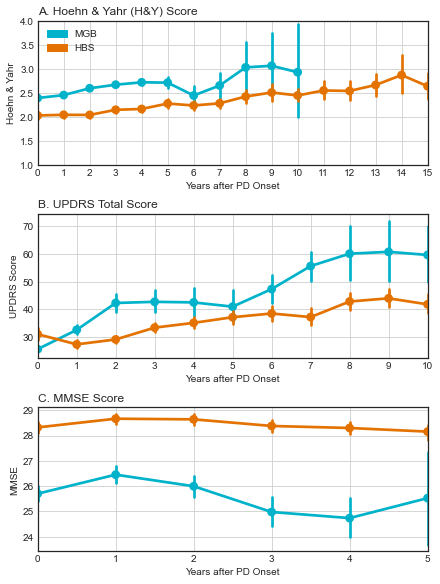

In [6]:
import seaborn as sns
from scipy.stats import linregress
import matplotlib.patches as mpatches

plt.style.use('seaborn-white')

layout = """
    A
    B
    C
    """

fig = plt.figure(constrained_layout=True, figsize=(6, 8))
ax_dict = fig.subplot_mosaic(layout)

combined_plots_years = 11
hbs_plot_years = 16

color_dict = {
    'mgb': '#00b2ca',
    'optum': '#1d4e89',
    'fox': '#fdbf6f',
    'hbs': '#e47200',
}

## A
query = """
SELECT h.EMPI, CAST(ct.FirstDiag as date) FirstDiagDate,
       Cast(h.Date as date) HYDate,
       ct.DaysToDiag as CovToPD,
       DATEDIFF(year, CAST(ct.FirstDiag as date), CAST(h.Date as date)) yearsToHY,
       hy
FROM pd.dbo.CoverageTime ct
JOIN pd.dbo.hy h
    ON h.EMPI = ct.EMPI;
"""
df = pd.read_sql(query, cn)

plot_df = df[df['hy']>1]
plot_df = df[df['CovToPD']>365]
plot_df = plot_df[(plot_df['yearsToHY'] < 13) & (plot_df['yearsToHY'] >= 0)]

plot_df.groupby('yearsToHY')['hy'].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9])[['count', 'mean', 'std', '10%', '25%', '50%', '75%', '90%']] #percentiles=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

measure = 'hy'
    
plot_df = plot_df[plot_df['yearsToHY'] < combined_plots_years]
groupings = 1
plot_df['YearGroup'] = (plot_df['yearsToHY'] / groupings).astype('int') * groupings
print('MGB value counts', plot_df['YearGroup'].value_counts())
sns.pointplot(data=plot_df, x="YearGroup", y=measure, ci=95, ax=ax_dict['A'], color = color_dict['mgb'])


hbs_df = pd.read_csv('../data/hbs.csv')
hbs_df = hbs_df[hbs_df['AgeOnSet']>30]

hbs_df['PDYears'] = hbs_df['Age']-hbs_df['AgeOnSet']
hbs_df = hbs_df[hbs_df['PDYears'] < hbs_plot_years]
groupings = 1
hbs_df['YearGroup'] = (hbs_df['PDYears'] / groupings).astype('int') * groupings
print(hbs_df['YearGroup'].value_counts())
sns.pointplot(data=hbs_df, x="YearGroup", y='HY', ci=95, ax=ax_dict['A'], color=color_dict['hbs'])

ax_dict['A'].set_ylim(1, 4)
ax_dict['A'].set_xlim(0, 15)
ax_dict['A'].set_xlabel('Years after PD Onset')
ax_dict['A'].set_xticklabels(list(range(16)))
# ax.set_xticklabels(['0-1', '1-2', '2-3', '3-4', '4-5', '5-6', '6-7', '7-8', '8-9', '9-10'])
ax_dict['A'].set_ylabel('Hoehn & Yahr')
ax_dict['A'].set_title('A. Hoehn & Yahr (H&Y) Score', loc='left')

ax_dict['A'].grid()

mgb_patch = mpatches.Patch(color=color_dict['mgb'], label='MGB')
hbs_patch = mpatches.Patch(color=color_dict['hbs'], label='HBS')
ax_dict['A'].legend(handles=[mgb_patch, hbs_patch])

#### B
measure = 'mmse'
query = """
SELECT ct.EMPI, CAST(ct.FirstDiag as date) FirstDiagDate,
       Cast(m.Date as date) MMSEDate,
       ct.DaysToDiag as CovToPD,
       DATEDIFF(year, CAST(ct.FirstDiag as date), CAST(m.Date as date)) yearsToU,
       mmse
FROM pd.dbo.CoverageTime ct
JOIN (SELECT * FROM pd.dbo.mmse where mmse is not null and ISNUMERIC(mmse) = 1) m
    ON m.EMPI = ct.EMPI;
"""
df = pd.read_sql(query, cn)
df['mmse'] = df['mmse'].astype(int)

plot_df = df[df['mmse']>0]
plot_df = df[df['CovToPD']>365]
plot_df = plot_df[(plot_df['yearsToU'] < 6) & (plot_df['yearsToU'] >= 0)]

plot_df.groupby('yearsToU')['mmse'].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9])[['count', 'mean', 'std', '10%', '25%', '50%', '75%', '90%']] #percentiles=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

sns.pointplot(data=plot_df, x="yearsToU", y=measure, ci=95, ax=ax_dict['C'], color =color_dict['mgb'])

hbs_df = pd.read_csv('../data/hbs.csv')
hbs_df = hbs_df[hbs_df['AgeOnSet']>30]

hbs_df['PDYears'] = hbs_df['Age']-hbs_df['AgeOnSet']

hbs_df = hbs_df[hbs_df['PDYears'] < 6]
groupings = 1
hbs_df['YearGroup'] = (hbs_df['PDYears'] / groupings).astype('int') * groupings
print(hbs_df['YearGroup'].value_counts())
sns.pointplot(data=hbs_df, x="YearGroup", y='MMSE', ci=95, ax=ax_dict['C'], color=color_dict['hbs'])

ax_dict['C'].set_xlabel('Years after PD Onset')
ax_dict['C'].set_xlim(0, 5)
ax_dict['C'].set_ylabel('MMSE')
ax_dict['C'].set_title('C. MMSE Score', loc='left')
ax_dict['C'].grid()


### C
query = """
SELECT ct.EMPI, CAST(ct.FirstDiag as date) FirstDiagDate,
       Cast(u.Date as date) UPDRSDate,
       ct.DaysToDiag as CovToPD,
       DATEDIFF(year, CAST(ct.FirstDiag as date), CAST(u.Date as date)) yearsToU,
       u.updrs
FROM pd.dbo.CoverageTime ct
JOIN (SELECT * FROM pd.dbo.updrs where updrs is not null) u
    ON u.EMPI = ct.EMPI;
"""
df = pd.read_sql(query, cn)
df.head()
plot_df = df[df['updrs']>0]
# plot_df['updrs'] = plot_df['updrs']*(1+plot_df['yearsToU']/10)
# plot_df = df[df['CovToPD']>365]
plot_df = plot_df[(plot_df['yearsToU'] < combined_plots_years) & (plot_df['yearsToU'] >= 0)]

plot_df.groupby('yearsToU')['updrs'].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9])[['count', 'mean', 'std', '10%', '25%', '50%', '75%', '90%']] #percentiles=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

measure = 'updrs'
plot_df = plot_df[plot_df['yearsToU'] < combined_plots_years]
groupings = 1
plot_df['updrs'] = plot_df['updrs'] * ((plot_df['yearsToU']/10) + 1) 
plot_df['YearGroup'] = (plot_df['yearsToU'] / groupings).astype('int') * groupings
sns.pointplot(data=plot_df, x="yearsToU", y='updrs', ci=95, ax=ax_dict['B'], color =color_dict['mgb'])


hbs_df = pd.read_csv('../data/hbs.csv')
hbs_df = hbs_df[hbs_df['AgeOnSet']>30]

hbs_df['PDYears'] = hbs_df['Age']-hbs_df['AgeOnSet']
hbs_df = hbs_df[hbs_df['PDYears'] < combined_plots_years]
groupings = 1
hbs_df['YearGroup'] = (hbs_df['PDYears'] / groupings).astype('int') * groupings
print(hbs_df['YearGroup'].value_counts())
sns.pointplot(data=hbs_df, x="YearGroup", y='UPDRS_Total', ci=95, ax=ax_dict['B'], 
              color=color_dict['hbs'])

ax_dict['B'].set_xlim(0, 10)
ax_dict['B'].set_xlabel('Years after PD Onset')
ax_dict['B'].set_ylabel('UPDRS Score')
ax_dict['B'].set_title('B. UPDRS Total Score', loc='left')
ax_dict['B'].grid()
plt.savefig('./figures/figure1.png', dpi=300)
# plt.tight_layout()
plt.show()
